# Телеком

Оператор связи *"Ниединогоразрыва.ком"* хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Цель проекта
**Разработать модель машинного обучения бинарной классификации, которая по различным характеристикам клиента сможет прогнозировать, планирует ли клиент расторгнуть контракт и отказать от услуг телекоммуникационного оператора.**

### Методология проекта
1. Загрузить данные, понять содержание данные, соединить в единый датасет.
2. Изучить предложенные данные, заполнить пропуски, проверить данные на дубликаты (явные и неявные). Подготовить данные к дальнейшему анализу.
3. Проверить корреляционную зависимость, исключить столбцы с признаками, которые имеют коэффициенты корреляции Пирсона выше 0.8.
4. Изучить значение целевого признака, проверить на наличие в нем дисбаланса.
5. Разработать и обучить несколько моделей машинного обучения для решения задачи бинарной классификации. Выбрать наилучшую модель по метрике качества с помощью поиска по сетке или кросс-валидации, протестировать модель на тестовых данных. При разработке модели учитывать проблему переобучения; провести масштабирование и нормализацию признаков, где необходимо.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (*DSL*, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

*Описание проекта в Notion [здесь](https://concrete-web-bad.notion.site/20b6db57bf464afe86232e26190285e5).*

In [2]:
pip install -q --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q dill

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import dill as pickle

from joblib import Parallel, delayed
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import fbeta_score, make_scorer, classification_report, roc_curve, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from statsmodels.tools.tools import add_constant
%matplotlib inline

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

## 1 Загрузка данных, преобработка данных

In [5]:
RANDOM_STATE = 300123

### 1.1 Загрузка данных

- ####  `contract`

In [6]:
# read the file handling exceptions
try:
    contract = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/final_provider/contract.csv') #, index_col=[0])
except FileNotFoundError:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') #, index_col=[0])

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
temp = contract[['customerID', 'EndDate']].copy()
temp

,customerID,EndDate
0,7590-VHVEG,No
1,5575-GNVDE,No
2,3668-QPYBK,2019-12-01 00:00:00
3,7795-CFOCW,No
4,9237-HQITU,2019-11-01 00:00:00
...,...,...
7038,6840-RESVB,No
7039,2234-XADUH,No
7040,4801-JZAZL,No
7041,8361-LTMKD,2019-11-01 00:00:00


In [9]:
churned = temp[temp['EndDate'] == 'No']
churned.head()

,customerID,EndDate
0,7590-VHVEG,No
1,5575-GNVDE,No
3,7795-CFOCW,No
6,1452-KIOVK,No
7,6713-OKOMC,No


In [10]:
churned['churned'] = int(1)
churned.drop(columns=['EndDate'])

,customerID,churned
0,7590-VHVEG,1
1,5575-GNVDE,1
3,7795-CFOCW,1
6,1452-KIOVK,1
7,6713-OKOMC,1
...,...,...
7037,2569-WGERO,1
7038,6840-RESVB,1
7039,2234-XADUH,1
7040,4801-JZAZL,1


In [11]:
j = churned.merge(contract[['customerID', 'BeginDate', 'EndDate', 'Type', 
                            'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 
                            'TotalCharges']], how='right', on='customerID')
j.shape

(7043, 10)

In [12]:
j['churned'].unique()

array([ 1., nan])

In [13]:
j['churned'].isnull().sum()

1869

In [14]:
contract_adj = j.copy()
contract_adj.head(3)

,customerID,EndDate_x,churned,BeginDate,EndDate_y,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,No,1.0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,No,1.0,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,NaN,NaN,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [15]:
contract_adj = contract_adj.drop(columns=['EndDate_x'])

In [16]:
contract_adj.head(3)

,customerID,churned,BeginDate,EndDate_y,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,1.0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,1.0,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,NaN,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [17]:
contract_adj.rename(columns = {'EndDate_y':'EndDate'}, inplace = True)

In [18]:
contract_adj.head(3)

,customerID,churned,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,1.0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,1.0,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,NaN,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [19]:
contract_adj['churned'] = contract_adj['churned'].fillna(0)
contract_adj.min()

customerID                         0002-ORFBO
churned                                   0.0
BeginDate                          2013-10-01
EndDate                   2019-10-01 00:00:00
Type                           Month-to-month
PaperlessBilling                           No
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          18.25
TotalCharges                                 
dtype: object

In [20]:
# Код ревьюера
contract_adj.isna().sum()

customerID          0
churned             0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [21]:
contract_adj.tail(3)

,customerID,churned,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7040,4801-JZAZL,1.0,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,0.0,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
7042,3186-AJIEK,1.0,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


In [22]:
contract_adj['begin_date'] = pd.to_datetime(contract_adj['BeginDate']).dt.date

In [23]:
contract_adj.loc[contract_adj['EndDate'] == 'No', 'EndDate'] = pd.to_datetime('2020-02-01')
contract_adj.min()

customerID                         0002-ORFBO
churned                                   0.0
BeginDate                          2013-10-01
Type                           Month-to-month
PaperlessBilling                           No
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          18.25
TotalCharges                                 
begin_date                         2013-10-01
dtype: object

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Обрати, пожалуйста, внимание на end_date (во что преобразуются нули)Здесь пропуски лучше заполнить датой выгрузки из бд</div>

In [24]:
contract_adj['end_date'] = pd.to_datetime(contract_adj['EndDate']).dt.date

In [25]:
contract_adj.head(5)

,customerID,churned,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_date,end_date
0,7590-VHVEG,1.0,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85,2020-01-01,2020-02-01
1,5575-GNVDE,1.0,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.5,2017-04-01,2020-02-01
2,3668-QPYBK,0.0,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-10-01,2019-12-01
3,7795-CFOCW,1.0,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75,2016-05-01,2020-02-01
4,9237-HQITU,0.0,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-09-01,2019-11-01


In [26]:
contract_adj.shape

(7043, 11)

In [27]:
contract_adj.describe()

,churned,MonthlyCharges
count,7043.000000,7043.000000
mean,0.734630,64.761692
std,0.441561,30.090047
min,0.000000,18.250000
25%,0.000000,35.500000
50%,1.000000,70.350000
75%,1.000000,89.850000
max,1.000000,118.750000


In [28]:
contract_adj.isnull().sum()

customerID          0
churned             0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
begin_date          0
end_date            0
dtype: int64

In [29]:
contract_adj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   churned           7043 non-null   float64
 2   BeginDate         7043 non-null   object 
 3   EndDate           7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   object 
 9   begin_date        7043 non-null   object 
 10  end_date          7043 non-null   object 
dtypes: float64(2), object(9)
memory usage: 660.3+ KB


In [30]:
# изменим тип данных, где приведены целочисленные значения
contract_adj['churned'] = contract_adj['churned'].astype('int')

In [31]:
contract_adj['TotalCharges'] = np.floor(pd.to_numeric(contract_adj['TotalCharges'], errors='coerce')).astype('float64')

In [32]:
contract_adj = contract_adj.drop(columns=['BeginDate'])
contract_adj = contract_adj.drop(columns=['EndDate'])

In [33]:
contract_adj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   churned           7043 non-null   int64  
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   begin_date        7043 non-null   object 
 8   end_date          7043 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.2+ KB


In [34]:
contract_adj.columns[contract_adj.isnull().any()]

Index(['TotalCharges'], dtype='object')

### *Вывод `contract`:* В данных создана отдельная колонка бинарного целевого признака со значениями 0, 1 в зависимости от того, являлся ли клиент действующим или нет. Решение было принято на основе наличия конечной даты контакта в исходных данных `EndDate`. Также были изменены типы переменных, вместо исходных колонок с датой начало и окончаения контракта в разных форматах, были созданы две новые колонки в едином формате даты. Финальная версия данных `contract` содержит 9 признаков (включая целевой) и 7043 наблюдения и готова к дальнейшему использованию. В колонке `TotalCharges` содержатся пропущенные значения. 

- ####  `internet`

In [35]:
# read the file handling exceptions
try:
    internet = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/final_provider/internet.csv') #, index_col=[0])
except FileNotFoundError:
    internet = pd.read_csv('/datasets/final_provider/internet.csv') #, index_col=[0])

In [36]:
internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [37]:
# проверка на пропущенные значения и дубликаты
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

### *Вывод:* Данные `internet` содержат категориальные переменные, не содержат пропусков. Аномальных значений в категориях не обнаружено. Данные готовы к дальнейшему анализу.

- ####  `personal`

In [38]:
# read the file handling exceptions
try:
    personal = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/final_provider/personal.csv') #, index_col=[0])
except FileNotFoundError:
    personal = pd.read_csv('/datasets/final_provider/personal.csv') #, index_col=[0])

In [39]:
personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [40]:
# проверка на пропущенные значения и дубликаты
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [41]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [42]:
personal['SeniorCitizen'].unique()

array([0, 1])

In [43]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [44]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

### *Вывод:* Данные `personal` содержат категориальные переменные, не содержат пропусков. Аномальных значений в категориях не обнаружено. Данные готовы к дальнейшему анализу.

- ####  `phone`

In [45]:
# read the file handling exceptions
try:
    phone = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/final_provider/phone.csv') #, index_col=[0])
except FileNotFoundError:
    phone = pd.read_csv('/datasets/final_provider/phone.csv') #, index_col=[0])

In [46]:
phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [47]:
# проверка на пропущенные значения и дубликаты
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

### *Вывод:* Данные `phone` содержат категориальные переменные, не содержат пропусков. Аномальных значений в категориях не обнаружено. Данные готовы к дальнейшему анализу.

### *Общий вывод:* Все четыре датасета подготовлены к дальнейшему анализу.

## 2 Исследовательский анализ данных
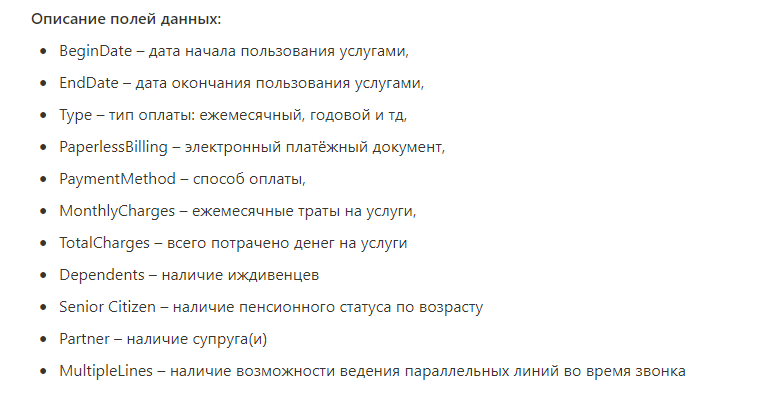

### 2.1 Подготовка финального датасета

In [48]:
df = pd.merge(contract, internet, how='left', on='customerID').merge(personal, how='left',  on='customerID').merge(phone, how='left', on='customerID')

In [49]:
df.shape

(7043, 20)

In [50]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


### 2.2 Обработка пропусков

In [52]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
InternetService,22.000000
OnlineSecurity,22.000000


In [53]:
#filling NA to No
df['InternetService'] = df['InternetService'].fillna('No')
df['OnlineSecurity'] =df['OnlineSecurity'].fillna('No')
df['OnlineBackup'] = df['OnlineBackup'].fillna('No')
df['DeviceProtection'] = df['DeviceProtection'].fillna('No')
df['TechSupport'] = df['TechSupport'].fillna('No')
df['StreamingTV'] = df['StreamingTV'].fillna('No')
df['StreamingMovies'] = df['StreamingMovies'].fillna('No')
df['MultipleLines'] = df['MultipleLines'].fillna('No')

### *Вывод:* В колонке ```MultipleLines``` пропуски в данных занимают менее 10% объема наблюдений, их можно безопасно удалить, но лучше поставить заглушку ввиду небольшого объема данных. Пропуски в колонках ```InternetService```, ```OnlineSecurity```, ```OnlineBackup```, ```DeviceProtection```, ```TechSupport```, ```StreamingTV```, ```StreamingMovies``` необходимо заполнить.

In [54]:
temp = df[['customerID', 'EndDate']].copy()
churned = temp[temp['EndDate'] == 'No']
churned['churned'] = int(1)
churned.drop(columns=['EndDate'])

,customerID,churned
0,7590-VHVEG,1
1,5575-GNVDE,1
3,7795-CFOCW,1
6,1452-KIOVK,1
7,6713-OKOMC,1
...,...,...
7037,2569-WGERO,1
7038,6840-RESVB,1
7039,2234-XADUH,1
7040,4801-JZAZL,1


In [55]:
# create new column churned
df['churned'] = df['EndDate'].apply(lambda val: 1 if val == 'No' else 0)

In [56]:
# create new columns begin_date, end_date
df['begin_date'] = pd.to_datetime(df['BeginDate']).dt.date
df.loc[df['EndDate'] == 'No', 'EndDate'] = pd.to_datetime('2020-02-01')
df['end_date'] = pd.to_datetime(df['EndDate']).dt.date
df = df.drop(columns=['BeginDate', 'EndDate'])

In [57]:
df['TotalCharges'] = df['TotalCharges'].astype(str)

In [58]:
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [59]:
df.isna().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
churned             0
begin_date          0
end_date            0
dtype: int64

In [60]:
df.isnull().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
churned             0
begin_date          0
end_date            0
dtype: int64

In [61]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
customerID,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000


### 2.3 Проверка данных на явные дубликаты

In [62]:
df.duplicated().sum()

0

### 2.4 Финальная проверка таргета на дисбаланс и аномалии различного рода

In [63]:
df['churned'].unique()

array([1, 0])

In [64]:
# проверка на дисбаланс
df['churned'].value_counts()

1    5163
0    1869
Name: churned, dtype: int64

### *Вывод:* Целевой признак не сбалансирован, мажоритарный класс 1.

### 2.5 Проверка признаков на мультиколлинеарность

#### 2.5.1 Проверка числовых признаков на мультиколлинеарность коррелляцией Пирсона

In [65]:
df.isna().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
churned             0
begin_date          0
end_date            0
dtype: int64

In [66]:
#Код ревьюера
df = df.dropna()

In [67]:
df_filled = df.copy()

In [68]:
d_int = df_filled[['MonthlyCharges',
                  'TotalCharges']]

In [69]:
d_int.corr()

,MonthlyCharges,TotalCharges
MonthlyCharges,1.000000,0.651065
TotalCharges,0.651065,1.000000


### *Вывод:* Коэффициенты Пирсона не превышают величины абсолютных значений 0.8, значит, допустимы к использованию в модели.

Перейдем к анализу мультикорреляции категориальных признаков.

#### 2.5.2 Поиск зависимостей между категориальными признаками проводим с помощью [коэффициента VIF](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b).

In [70]:
cols = ['Type',
        'PaperlessBilling',
        'PaymentMethod',
        'gender',
        'SeniorCitizen',
        'Partner',
        'Dependents',
        'MultipleLines',
        'InternetService',
        'OnlineSecurity',
        'OnlineBackup',
        'DeviceProtection',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies']

d_categ = df_filled[cols]

In [71]:
d_categ.head(4)

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Month-to-month,Yes,Electronic check,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No
1,One year,No,Mailed check,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,Month-to-month,Yes,Mailed check,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,One year,No,Bank transfer (automatic),Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No


In [72]:
# закодируем категориальные признаки, чтобы проверить мультиколлинеарность
# define ordinal encoding
ordinalencoder = OrdinalEncoder()

In [73]:
# encode data
result = ordinalencoder.fit_transform(df_filled[cols])
result = pd.DataFrame(result)
result.columns = cols
result = result.join(d_int)

In [74]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# cols=['Type',       'PaperlessBilling',
#                     'PaymentMethod',
#                     'gender',
#       'SeniorCitizen',
#                     'Partner',
#                     'Dependents',
#                     'MultipleLines',
#                     'InternetService',
#                     'OnlineSecurity',
#                     'OnlineBackup',
#                     'DeviceProtection',
#                     'TechSupport',
#                     'StreamingTV',
#                     'StreamingMovies']

# result = ordinalencoder.fit_transform(d_categ[cols])
# result = pd.DataFrame(result)
# result.columns= cols
# result = result.join(d_int)
# result.loc[result['TotalCharges'].isna()]
# vif = pd.DataFrame()
# vif['VIF'] = [variance_inflation_factor(result.values, i) for i in range(result.shape[1])]
# vif['variable'] = result.columns
# vif

In [75]:
result.isna().sum()

Type                 0
PaperlessBilling     0
PaymentMethod        0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MonthlyCharges      11
TotalCharges        11
dtype: int64

In [76]:
result.isnull().sum()

Type                 0
PaperlessBilling     0
PaymentMethod        0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MonthlyCharges      11
TotalCharges        11
dtype: int64

In [77]:
result = result.dropna()

In [78]:
# calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(result.values, i) for i in range(result.shape[1])]
vif['variable'] = result.columns
vif

,VIF,variable
0,2.464364,Type
1,2.574775,PaperlessBilling
2,2.725080,PaymentMethod
3,1.915912,gender
4,1.333438,SeniorCitizen
5,2.688919,Partner
6,1.942479,Dependents
7,2.057547,MultipleLines
8,3.125101,InternetService
9,1.847507,OnlineSecurity


#### 2.5.3 Поиск зависимостей между категориальными переменными с использованием [анализатора Phi_K](https://phik.readthedocs.io/en/latest/introduction.html)

In [79]:
!pip install -q phik

In [80]:
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [81]:
phik_overview = result.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges']


,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges
Type,1.00,0.11,0.28,0.00,0.09,0.18,0.15,0.07,0.50,0.15,0.10,0.14,0.18,0.07,0.07,0.00,0.07
PaperlessBilling,0.11,1.00,0.37,0.00,0.24,0.01,0.17,0.25,0.23,0.00,0.20,0.16,0.05,0.34,0.33,0.03,0.00
PaymentMethod,0.28,0.37,1.00,0.00,0.29,0.24,0.22,0.34,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.01,0.03
gender,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.01,0.00
SeniorCitizen,0.09,0.24,0.29,0.00,1.00,0.02,0.32,0.22,0.16,0.06,0.10,0.09,0.09,0.16,0.18,0.00,0.01
Partner,0.18,0.01,0.24,0.00,0.02,1.00,0.65,0.22,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.03,0.06
Dependents,0.15,0.17,0.22,0.00,0.32,0.65,1.00,0.03,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.00,0.04
MultipleLines,0.07,0.25,0.34,0.00,0.22,0.22,0.03,1.00,0.23,0.15,0.31,0.31,0.16,0.39,0.40,0.07,0.05
InternetService,0.50,0.23,0.32,0.00,0.16,0.00,0.11,0.23,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.09,0.00
OnlineSecurity,0.15,0.00,0.26,0.02,0.06,0.22,0.12,0.15,0.24,1.00,0.43,0.42,0.53,0.27,0.29,0.03,0.03


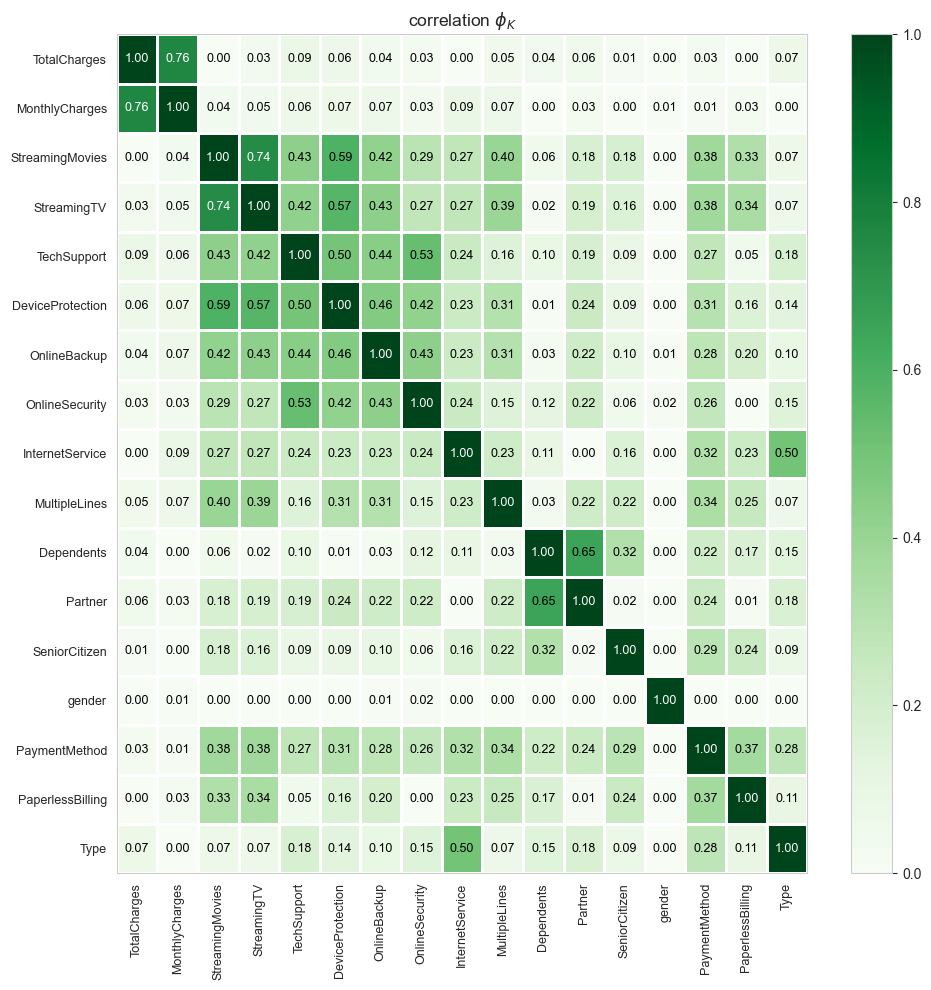

In [82]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, 
                        figsize=(10, 10))
plt.tight_layout();

### *Вывод:* Анализ корреляций показал, что из данных для дальнейшего анализа необходимо исключить признак 'MonthlyCharges'.

In [83]:
data = df_filled.drop(columns='MonthlyCharges')

### *Вывод:* Категориальных признаков с высокой мультиколлинеарностью в данных нет.

### 2.6 Исследовательский анализ данных

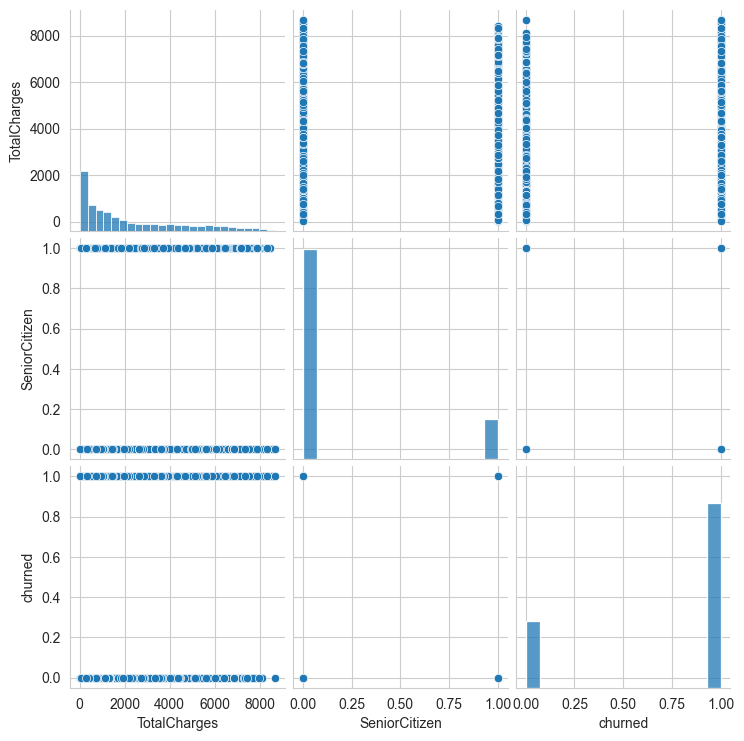

In [84]:
sns.pairplot(data);

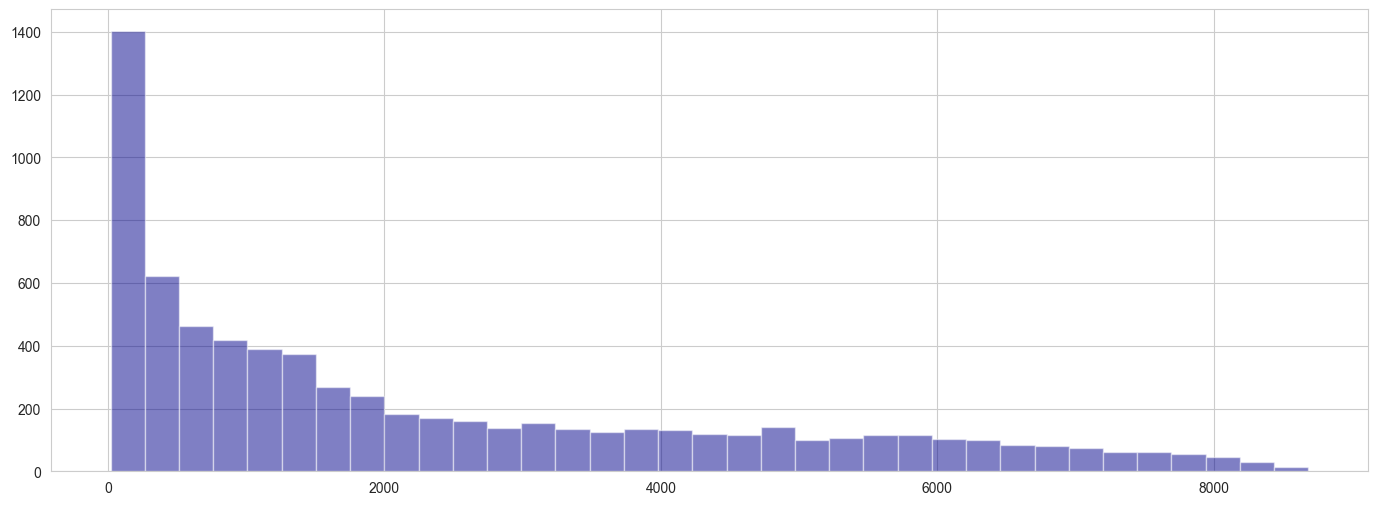

In [85]:
data['TotalCharges'].hist(bins=35, alpha=0.5, color='darkblue', figsize=(17, 6));

In [86]:
def desc_stat(data, column):
    # descriptive statistics
    print(data[column].describe())
    data.boxplot(column=column, figsize=(3,7));
    plt.title('Descriptive Statistics')
    plt.show()
    data[column].hist(bins=30, range=(0, 110), figsize=(15, 5));

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


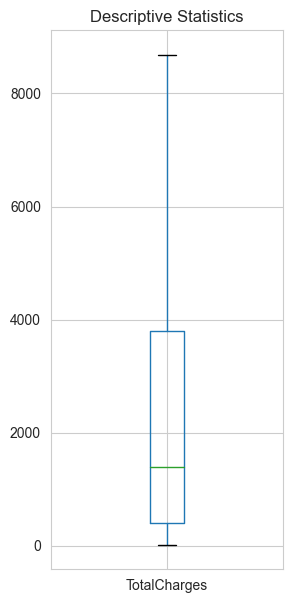

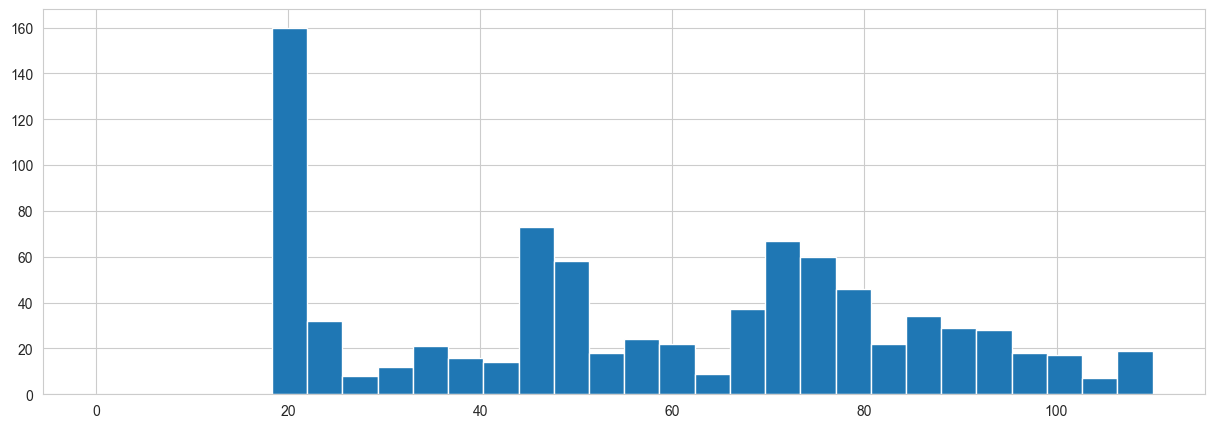

In [87]:
desc_stat(data, 'TotalCharges')

In [88]:
data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

### *Вывод:* Числовые признаки не содержат выборосов, однако у признака ```TotalCharges``` смещенное распределение. 

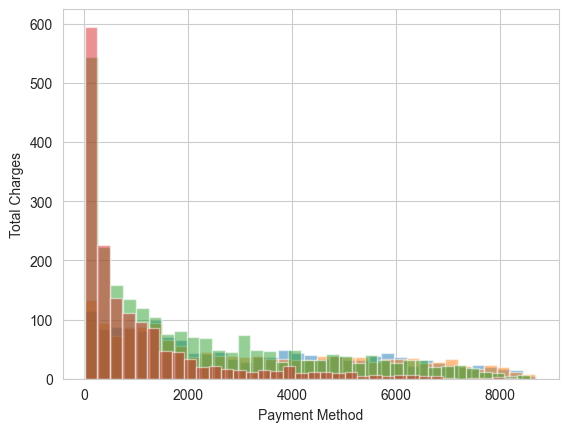

In [89]:
data.groupby('PaymentMethod')['TotalCharges'].plot(kind='hist', bins=35, alpha=0.5)
# plt.legend(['Smart', 'Ultra'])
plt.xlabel('Payment Method')
plt.ylabel('Total Charges')
plt.show();

In [90]:
d_plot = data.copy()

In [91]:
d_plot['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [92]:
d_plot['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [93]:
d_plot['year_begin'] = pd.DatetimeIndex(d_plot['begin_date']).year

In [94]:
d_plot['year_end'] = pd.DatetimeIndex(d_plot['end_date']).year

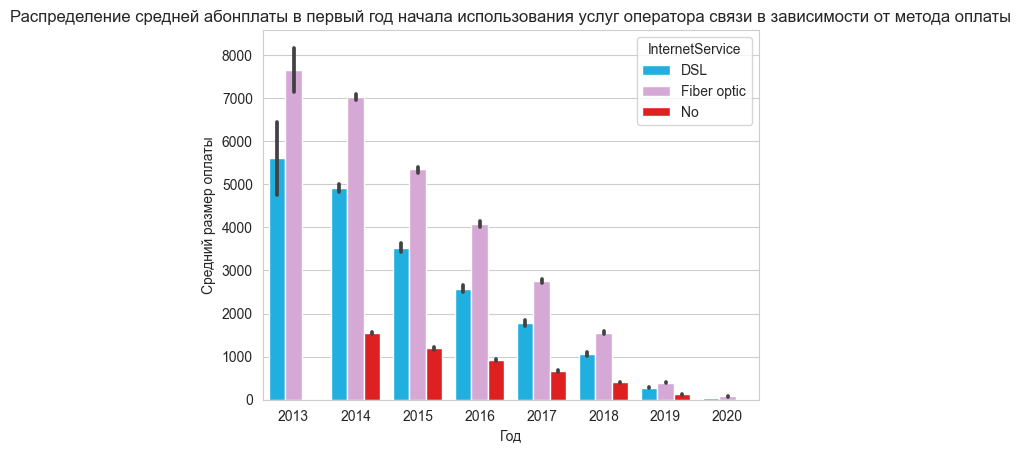

In [95]:
ax = sns.barplot(x='year_begin',
            y='TotalCharges',
            hue="InternetService",
            data=d_plot,
            palette=['deepskyblue', 'plum', 'r', 'blueviolet'])

ax.set_title('Распределение средней абонплаты в первый год начала использования услуг оператора связи в зависимости от метода оплаты')
ax.set(xlabel='Год', ylabel='Средний размер оплаты');

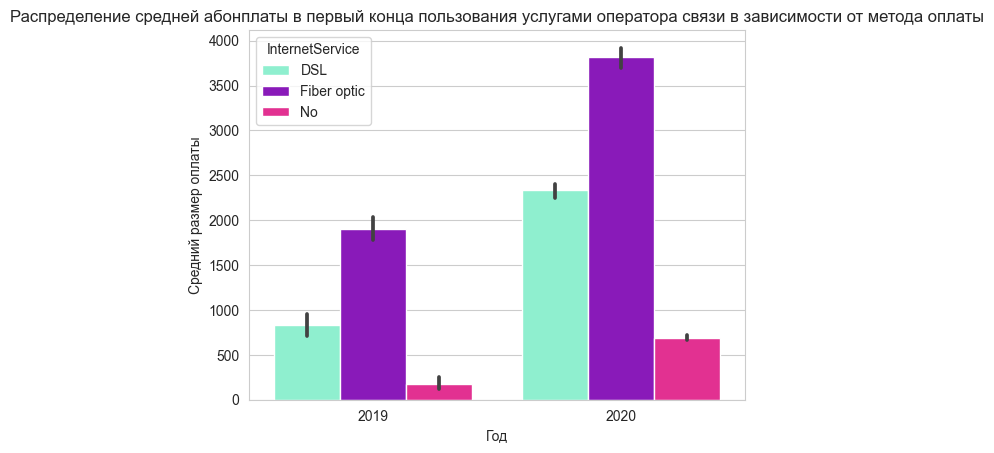

In [96]:
ax = sns.barplot(x='year_end',
            y='TotalCharges',
            hue="InternetService",
            data=d_plot,
            palette=['aquamarine', 'darkviolet', 'deeppink', 'hotpink'])

ax.set_title('Распределение средней абонплаты в первый конца пользования услугами оператора связи в зависимости от метода оплаты')
ax.set(xlabel='Год', ylabel='Средний размер оплаты');

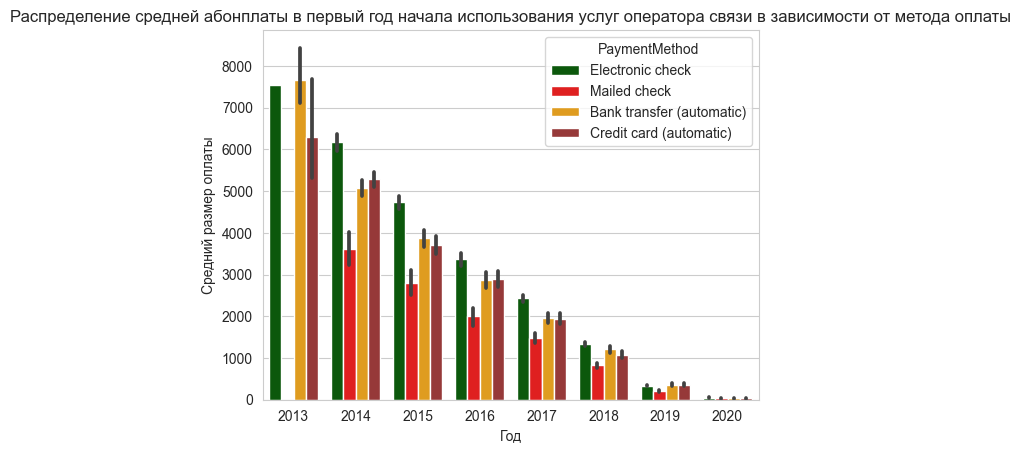

In [97]:
ax = sns.barplot(x='year_begin',
            y='TotalCharges',
            hue="PaymentMethod",
            data=d_plot,
            palette=['darkgreen', 'red', 'orange', 'brown'])

ax.set_title('Распределение средней абонплаты в первый год начала использования услуг оператора связи в зависимости от метода оплаты')
ax.set(xlabel='Год', ylabel='Средний размер оплаты');

Text(0, 0.5, 'Средняя абонплаты в 1-ый год')

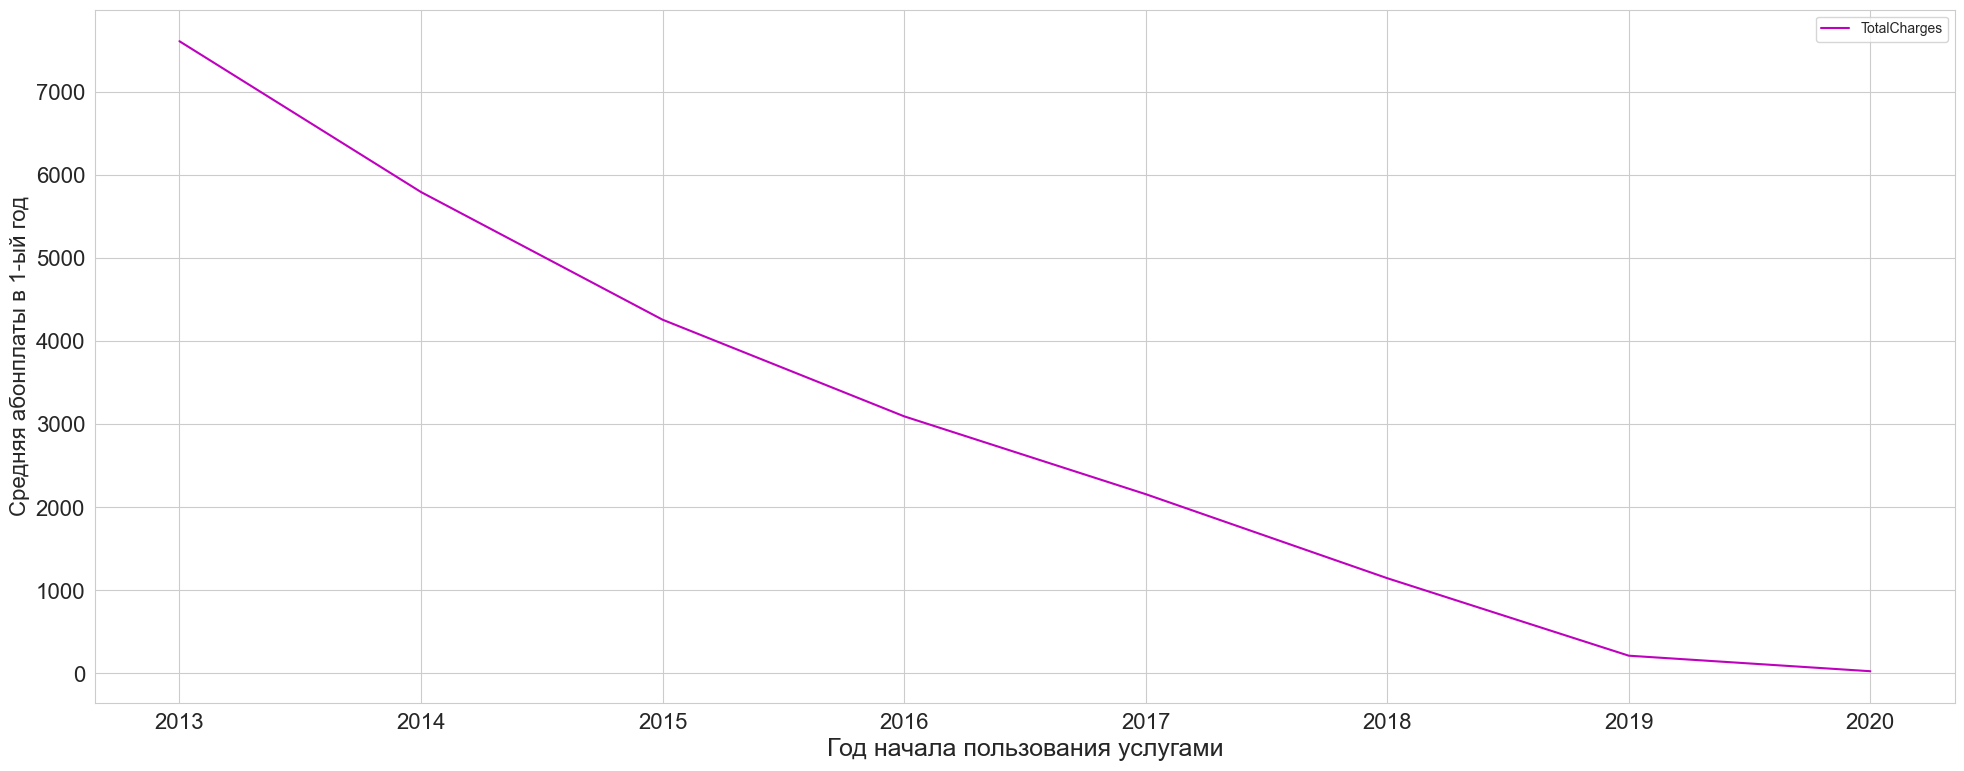

In [98]:
(
    d_plot
    .pivot_table(index=['year_begin'], values='TotalCharges', aggfunc='median')
    .plot(grid=True, figsize=(24, 9), color='m', fontsize=16)
);

plt.xlabel('Год начала пользования услугами', fontsize=18)
plt.ylabel('Средняя абонплаты в 1-ый год', fontsize=16)

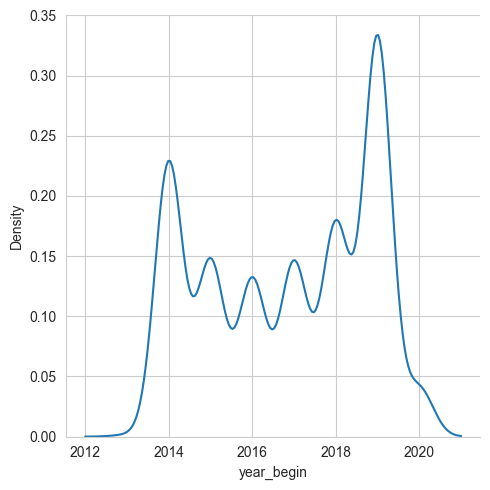

In [99]:
sns.displot(x=d_plot['year_begin'], kind='kde');

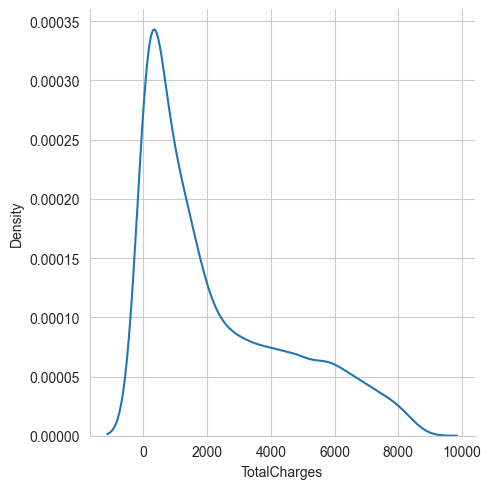

In [100]:
sns.displot(x=d_plot['TotalCharges'], kind='kde');

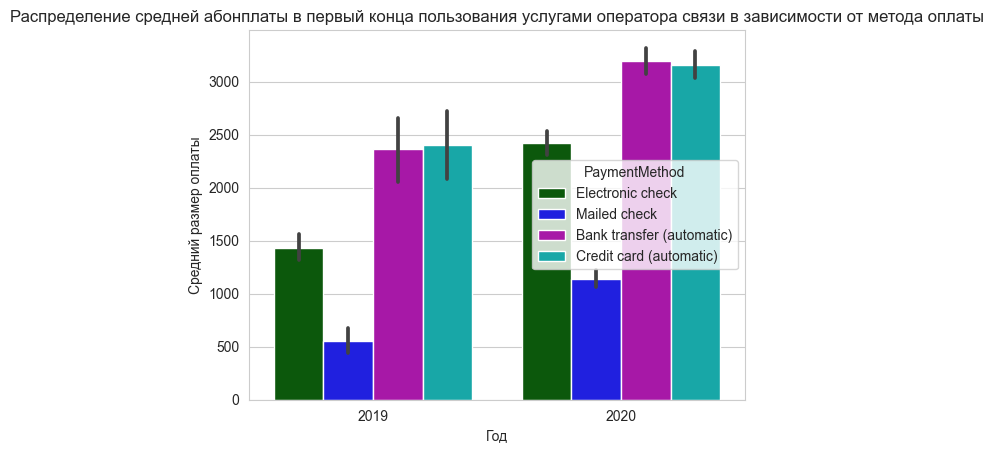

In [101]:
ax = sns.barplot(x='year_end',
            y='TotalCharges',
            hue="PaymentMethod",
            data=d_plot,
            palette=['darkgreen', 'blue', 'm', 'c'])

ax.set_title('Распределение средней абонплаты в первый конца пользования услугами оператора связи в зависимости от метода оплаты')
ax.set(xlabel='Год', ylabel='Средний размер оплаты');

### *Вывод:* В 2014-ом году наблюдается стремительный скачок новый абонентов. Количество пользователей, который начали пользоваться услугами оператора, с 2015 по 2019 годы колеблется, к 2020-ому году - люди снова начинают пользоваться услгами телеоператора. Средний размер годовой оплаты услуг данного оператора связи стремительно снижался с 2013 по 2019 годы, к 2020-ому гоу падение замедлилось. Большая часть пользователей проводят оплату онлайн через мобильный банкинг или по карте; меньшая часть - через счета по электронной почте. Наиболее используемая технология подключения - оптоволокно.

## 3 Модели

### 3.1 Деление выборки на подвыборки

```
- 75% train_data
- 25% test_data
```

In [102]:
data = data.drop(columns='customerID').copy()

In [103]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

print('Размер обучающей выборки:', train_data.shape[0])
print('Размер тестовой выборки:', test_data.shape[0])

Размер обучающей выборки: 5274
Размер тестовой выборки: 1758


### 3.2 Кодирование признаков (после деления выборки на подвыборки)

Есть несколько способов, как кодировать переменные:

- get_dummies()
- OHE
- OrdinalEncoding
- LabelEncoding

Мы не хотим увеличивать количество колонок, поэтому в рамках данного проекта выбираем способ *OrdinalEncoding()*.

### Признаки, которые необходимо кодировать (только категориальные):
```
'Type',
'PaperlessBilling',
'PaymentMethod',
'gender',
'Partner',
'Dependents',
'MultipleLines',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies'

```

In [104]:
# from sklearn.preprocessing import MinMaxScaler
# train_data= train_data.drop(columns=['begin_date','end_date'])
# test_data = test_data.drop(columns=['begin_date','end_date'])
# num_columns=['TotalCharges']
# cat_columns=['Type',
#                                             'PaperlessBilling',
#                                             'PaymentMethod',
#                                             'gender',
#                                             'Partner',
#                                             'Dependents',
#                                             'MultipleLines',
#                                             'InternetService',
#                                             'OnlineSecurity',
#                                             'OnlineBackup',
#                                             'DeviceProtection',
#                                             'TechSupport',
#                                             'StreamingTV',
#                                             'StreamingMovies','SeniorCitizen']
# X_train = train_data.drop(['churned'], axis=1)
# y_train = train_data['churned']

# X_test = test_data.drop(['churned'], axis=1)
# y_test = test_data['churned']

# ordinalencoder = OrdinalEncoder()
# X_train[cat_columns] = ordinalencoder.fit_transform(X_train[cat_columns])
# X_test[cat_columns] = ordinalencoder.transform(X_test[cat_columns])

# scaler = MinMaxScaler()
# X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
# X_test[num_columns] = scaler.transform(X_test[num_columns])

In [105]:
# define ordinal encoding
ordinalencoder = OrdinalEncoder()

In [106]:
# transform data
result_train = ordinalencoder.fit_transform(train_data[['Type',
                                            'PaperlessBilling',
                                            'PaymentMethod',
                                            'gender',
                                            'Partner',
                                            'Dependents',
                                            'MultipleLines',
                                            'InternetService',
                                            'OnlineSecurity',
                                            'OnlineBackup',
                                            'DeviceProtection',
                                            'TechSupport',
                                            'StreamingTV',
                                            'StreamingMovies']])

result_train = pd.DataFrame(result_train)

print(type(result_train))
result_train.head(3)

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [107]:
# transform data
result_test = ordinalencoder.transform(test_data[['Type',
                                            'PaperlessBilling',
                                            'PaymentMethod',
                                            'gender',
                                            'Partner',
                                            'Dependents',
                                            'MultipleLines',
                                            'InternetService',
                                            'OnlineSecurity',
                                            'OnlineBackup',
                                            'DeviceProtection',
                                            'TechSupport',
                                            'StreamingTV',
                                            'StreamingMovies']])

result_test = pd.DataFrame(result_test)

print(type(result_train))
result_train.head(3)

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [108]:
columns = ['Type',
                                            'PaperlessBilling',
                                            'PaymentMethod',
                                            'gender',
                                            'Partner',
                                            'Dependents',
                                            'MultipleLines',
                                            'InternetService',
                                            'OnlineSecurity',
                                            'OnlineBackup',
                                            'DeviceProtection',
                                            'TechSupport',
                                            'StreamingTV',
                                            'StreamingMovies']
result_train.columns = columns
result_test.columns = columns

train_enc = result_train.join(train_data[['TotalCharges','begin_date','end_date','churned']].reset_index(drop=True))
test_enc = result_test.join(test_data[['TotalCharges','begin_date','end_date','churned']].reset_index(drop=True))

train_dropped = train_enc
test_dropped = test_enc
train_dropped.isna().sum().sum()

0

In [109]:
train_dropped.shape

(5274, 18)

In [110]:
test_dropped.shape

(1758, 18)

In [111]:
train_dropped.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
gender              0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
TotalCharges        0
begin_date          0
end_date            0
churned             0
dtype: int64

In [112]:
test_dropped.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
gender              0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
TotalCharges        0
begin_date          0
end_date            0
churned             0
dtype: int64

In [113]:
train_dropped = train_dropped.dropna()

In [114]:
test_dropped = test_dropped.dropna()

In [115]:
train_dropped.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
gender              0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
TotalCharges        0
begin_date          0
end_date            0
churned             0
dtype: int64

In [116]:
test_dropped.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
gender              0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
TotalCharges        0
begin_date          0
end_date            0
churned             0
dtype: int64

### 3.3 После кодирования категориальных переменных выделяем `X, y` для обучения и тестирования моделей

In [117]:
X_train = train_dropped.drop(['churned'], axis=1)
y_train = train_dropped['churned']

X_test = test_dropped.drop(['churned'], axis=1)
y_test = test_dropped['churned']

print('Обучающая выборка (признаки):', X_train.shape[0])
print('Обучающая выборка (таргет)', y_train.shape[0])
print()
print('Тестовая выборка (признаки):', X_test.shape[0])
print('Тестовая выборка (таргет)', y_test.shape[0])

Обучающая выборка (признаки): 5274
Обучающая выборка (таргет) 5274

Тестовая выборка (признаки): 1758
Тестовая выборка (таргет) 1758


### 3.4 Масштабирование признаков

In [118]:
from sklearn.preprocessing import MinMaxScaler

In [119]:
X_train_n = X_train.drop(columns=['begin_date', 'end_date'])

In [120]:
X_test_n = X_test.drop(columns=['begin_date', 'end_date'])

In [121]:
#Код ревьюера
X_train_=X_train_n.copy()
X_test_ = X_test_n.copy()

In [122]:
#Код ревьюера
scaler = MinMaxScaler()
X_train_[['TotalCharges']] = scaler.fit_transform(X_train_[['TotalCharges']]) 
X_test_[['TotalCharges']] = scaler.transform(X_test_[['TotalCharges']])  

In [123]:
# вычисляем минимум и максимум по обучающим данным
scaler_train = MinMaxScaler().fit(X_train_n)

In [124]:
# вычисляем минимум и максимум по тестовым данным
scaler_test = MinMaxScaler().fit(X_test_n)

In [125]:
# масштабируем обучающие данные
X_train_scaled = scaler_train.transform(X_train_n)

In [126]:
# масштабируем тестовые данные и оцениваем качество на масштабированных данных
X_test_scaled = scaler_test.transform(X_test_n)

In [127]:
#Код ревьюера
X_train_scaled = X_train_
X_test_scaled = X_test_

In [128]:
X_test_scaled.head()

,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,TotalCharges
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.020188
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012093
2,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083216
3,2.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160836
4,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004143


### *Вывод:* Данные готовы для обучения моделей: пропуски заполнены, признаки проверены на мультиколлинеарность, выделены подвыборки (трейн, тест), выделен целевой признак, категориальные данные закодированы, числовые признаки приведены к единому масштабу.

## 4 Модели

### 4.4.1 Decision Tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [129]:
%%time
# Initiating and building Decision Tree model
parameters_dt = {
    'max_depth': [2, 3, 4, 5],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_DT = GridSearchCV(dt, param_grid=parameters_dt)
best_decision_tree_model = grid_DT.fit(X_train_scaled, y_train)
print('Наилучшие параметры для Decision Tree: {}'.format(best_decision_tree_model.best_params_))

Наилучшие параметры для Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
CPU times: user 1.11 s, sys: 33.7 ms, total: 1.14 s
Wall time: 1.23 s


### 4.4.2 Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [130]:
%%time
# Initiating and building Random Forest Regressor model
parameters_rf = {
    'n_estimators': [5, 10, 20, 50],
    'max_depth': [2, 3, 7],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
grid_RF = GridSearchCV(estimator=rf_model, param_grid=parameters_rf)
best_random_forest_model = grid_RF.fit(X_train_scaled, y_train)
print('Наилучшие параметры для Random Forest: {}'.format(best_random_forest_model.best_params_))

Наилучшие параметры для Random Forest: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50}
CPU times: user 12.1 s, sys: 266 ms, total: 12.4 s
Wall time: 12.8 s


### 4.4.3 Gradient Boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [131]:
%%time
param_grid={'n_estimators':[5,10], 
            'learning_rate': [0.1,0.04,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 
n_jobs=4

estimator = GradientBoostingClassifier(random_state=RANDOM_STATE) 
gb_classifier = GridSearchCV(estimator=estimator, 
                          cv=5, 
                          param_grid=param_grid, 
                          n_jobs=n_jobs)
    
best_gb_model = gb_classifier.fit(X_train_scaled, y_train)
print('Наилучшие параметры для Gradient Descent: {}'.format(best_gb_model.best_params_))

Наилучшие параметры для Gradient Descent: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 10}
CPU times: user 210 ms, sys: 23.8 ms, total: 234 ms
Wall time: 1.74 s


In [132]:
print(best_gb_model.best_estimator_)

GradientBoostingClassifier(max_depth=4, max_features=1.0, min_samples_leaf=3,
                           n_estimators=10, random_state=300123)


### 4.4.4 Сравнение качества моделей по кросс-валидации: 

- **Decision Tree**

In [133]:
best_score_dt = round(best_decision_tree_model.best_score_, 5)
print('Best score Decision Tree: {}'.format(best_score_dt))

Best score Decision Tree: 0.7901


In [134]:
train_predicted_dt = best_decision_tree_model.predict(X_train_scaled)
print("TRAIN Decision Tree Model, F1:", f1_score(y_train, train_predicted_dt))

TRAIN Decision Tree Model, F1: 0.8706086095992084


In [135]:
train_predicted_dt = best_decision_tree_model.predict(X_train_scaled)
print("TRAIN Decision Tree Model, accuracy:", accuracy_score(y_train, train_predicted_dt))

TRAIN Decision Tree Model, accuracy: 0.801668562760713


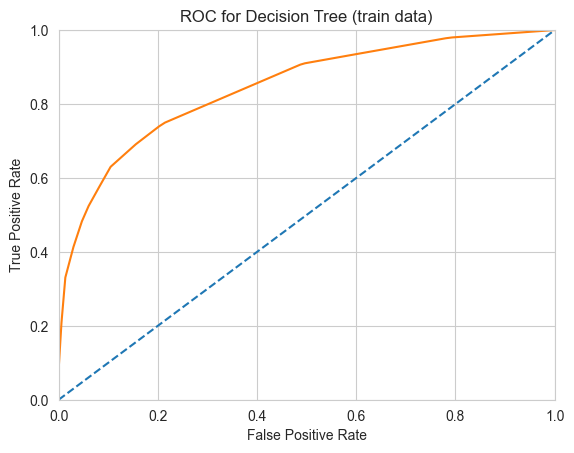

In [136]:
probabilities_train_dt = best_decision_tree_model.predict_proba(X_train_scaled)
probabilities_one_train_dt = probabilities_train_dt[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, probabilities_one_train_dt)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Decision Tree (train data)')
plt.show();

In [137]:
auc_roc_dt = roc_auc_score(y_train, probabilities_one_train_dt)
print(f'Decision Tree // model 1 AUC score: {auc_roc_dt}')

Decision Tree // model 1 AUC score: 0.8448383048017682


- **Random Forest**

In [138]:
best_score_rf = round(best_random_forest_model.best_score_, 5)
print('Best score Random Forest: {}'.format(best_score_rf))

Best score Random Forest: 0.79257


In [139]:
train_predicted_rf = best_random_forest_model.predict(X_train_scaled)
print("TRAIN Random Forest Model, F1:", f1_score(y_train, train_predicted_rf))

TRAIN Random Forest Model, F1: 0.8799707245669675


In [140]:
train_predicted_rf = best_random_forest_model.predict(X_train_scaled)
print("TRAIN Random Forest Model, accuracy:", accuracy_score(y_train, train_predicted_rf))

TRAIN Random Forest Model, accuracy: 0.8134243458475541


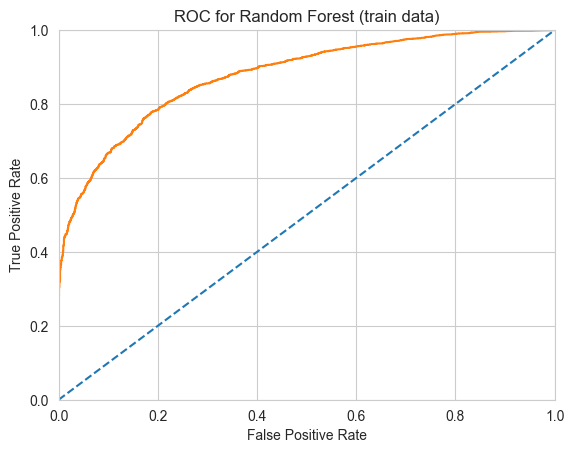

In [141]:
probabilities_train_rf = best_random_forest_model.predict_proba(X_train_scaled)
probabilities_one_train_rf = probabilities_train_rf[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, probabilities_one_train_rf)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Random Forest (train data)')
plt.show();

In [142]:
auc_roc_rf = roc_auc_score(y_train, probabilities_one_train_rf)
print(f'Random Forest // model 1 AUC score: {auc_roc_rf}')

Random Forest // model 1 AUC score: 0.8776294575671353


- **Gradient Boosting**

In [143]:
best_score_gb = round(best_gb_model.best_score_, 5)
print('Best score Gradient Boosting: {}'.format(best_score_gb))

Best score Gradient Boosting: 0.76925


In [144]:
train_predicted_gb = best_gb_model.predict(X_train_scaled)
print("TRAIN Random Forest Model, F1:", f1_score(y_train, train_predicted_rf))

TRAIN Random Forest Model, F1: 0.8799707245669675


In [145]:
train_predicted_gb = best_gb_model.predict(X_train_scaled)
print("TRAIN Gradient Boosting Model, accuracy:", accuracy_score(y_train, train_predicted_gb))

TRAIN Gradient Boosting Model, accuracy: 0.7677284793325749


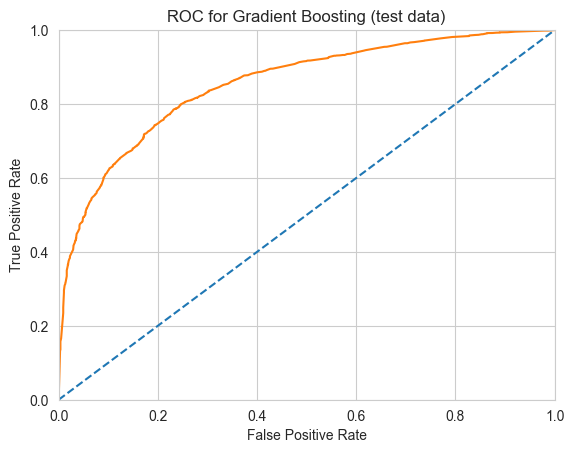

In [146]:
probabilities_train_gb = best_gb_model.predict_proba(X_train_scaled)
probabilities_one_train_gb = probabilities_train_gb[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, probabilities_one_train_gb)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Gradient Boosting (test data)')
plt.show();

In [147]:
auc_roc_gb = roc_auc_score(y_train, probabilities_one_train_gb)
print(f'Gradient Boosting // model 1 AUC score: {auc_roc_gb}')

Gradient Boosting // model 1 AUC score: 0.8540223921836052


### *Вывод:* Наивысший скор по кросс-валидации получил Random Forest.

## 5 Тестируем лучшую модель (Random Forest) на тестовой выборке и делаем тестовые предсказания

### 5.1 Тестируем Gradient Boosting

In [148]:
test_predicted_rf = best_random_forest_model.predict(X_test_scaled)
print("TEST RF Model, F1:", f1_score(y_test, test_predicted_rf))

TEST RF Model, F1: 0.8738640494365684


In [149]:
test_predicted_rf = best_random_forest_model.predict(X_test_scaled)
print("TRAIN RF Model, accuracy:", accuracy_score(y_test, test_predicted_rf))

TRAIN RF Model, accuracy: 0.8026166097838453


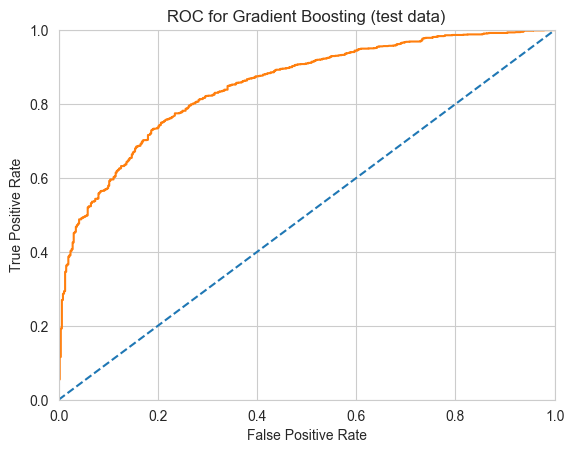

In [150]:
probabilities_test_rf = best_random_forest_model.predict_proba(X_test_scaled)
probabilities_one_test_rf = probabilities_test_rf[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test_rf)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Gradient Boosting (test data)')
plt.show();

In [151]:
auc_roc_rf = roc_auc_score(y_test, probabilities_one_test_rf)
print(f'Gradient Boosting // model 1 AUC score: {auc_roc_rf}')

Gradient Boosting // model 1 AUC score: 0.8494063557316485


### *Вывод:* Модель случайного леса показала наилучший результат. Модель слегка переобучается: на обучающей выборке AUC-ROC=0.88, на тестовой подвыборке AUC-ROC=0.85.

### 5.2 Предсказания

In [152]:
# Random Forest
y_pred_rf = best_random_forest_model.predict(X_test_scaled)
y_pred_rf

array([0, 1, 0, ..., 1, 1, 1])

In [153]:
test_dropped.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'TotalCharges', 'begin_date', 'end_date', 'churned'],
      dtype='object')

In [154]:
# X_test_df = test_dropped.drop(columns=['target'])
test_pred = test_dropped[['TotalCharges']]

In [155]:
test_pred['churned'] = best_random_forest_model.predict(X_test_scaled)

In [156]:
test_pred['predictions'] = np.round(best_random_forest_model.predict_proba(X_test_scaled),3)[:, 1]
test_pred.shape

(1758, 3)

In [157]:
test_pred_df = pd.DataFrame(test_pred)
test_pred_df

,TotalCharges,churned,predictions
0,193.80,0,0.378
1,123.65,1,0.815
2,740.00,0,0.473
3,1412.65,1,0.995
4,54.75,0,0.401
...,...,...,...
1753,1687.95,0,0.425
1754,84.20,1,0.826
1755,1725.00,1,0.992
1756,4738.30,1,0.878


In [158]:
# test_pred_df.to_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/test_pred_df.csv')

### 5.3 Изучим важность признаков

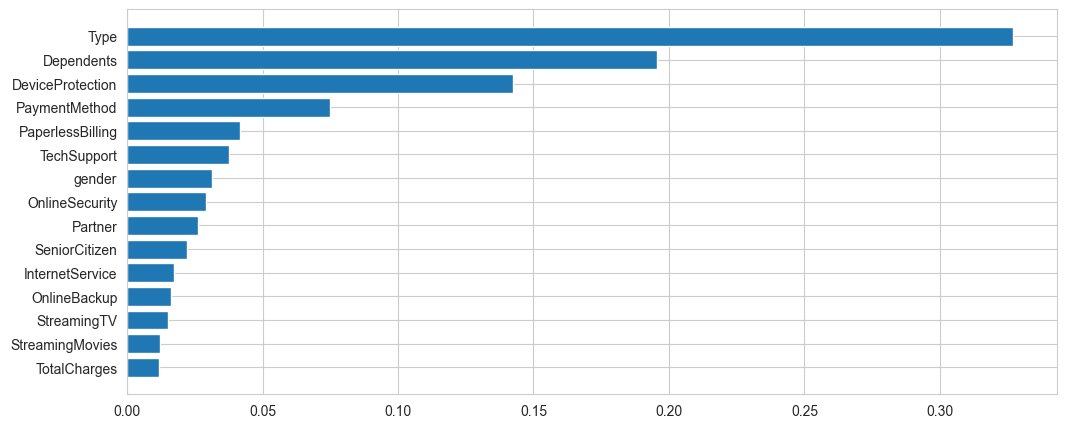

In [159]:
importance = best_random_forest_model.best_estimator_.feature_importances_
indices = np.argsort(importance)

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(test_data.drop(columns=['churned']).columns)[indices])

In [160]:
test_data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'churned',
       'begin_date', 'end_date'],
      dtype='object')

### 5.4 Изучим, насколько хорошо модель классифицирует целевое значение

In [161]:
print(classification_report(y_test, best_random_forest_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.69      0.45      0.55       461
           1       0.83      0.93      0.87      1297

    accuracy                           0.80      1758
   macro avg       0.76      0.69      0.71      1758
weighted avg       0.79      0.80      0.79      1758



### *Вывод*: Модель *случайного леса* показала наилучший результат. Модель слегка переобучается: на обучающей выборке AUC-ROC=0.87, на тестовой подвыборке AUC-ROC=0.85. Было выполнено тестирование модели  *случайного леса* на тестовой подвыборке и выявлена важность изучаемых признаков. По отчету о классификации (classification report) видим, что модель научилась хорошо предсказывать 1-й класс (F1-score=0.87) и хуже предсказывает 0-й класс (F1-score=0.55). Наиболее высокое влияние в модели оказывают признаки ```'PaperlessBilling'```, ```'DeviceProtection'```, ```'PaymentMethod'```, ```Dependents```, ```'gender'```, ```'TechSupport'```.

Precision: Out of all the players that the model predicted would get drafted, only 43% actually did.

Recall: Out of all the players that actually did get drafted, the model only predicted this outcome correctly for 36% of those players.

F1 Score: This value is calculated as:

F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
F1 Score: 2 * (.43 * .36) / (.43 + .36)
F1 Score: 0.40.
Since this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not players will get drafted.

Support: These values simply tell us how many players belonged to each class in the test dataset. We can see that among the players in the test dataset, 160 did not get drafted and 140 did get drafted.

# Отчетная часть

В рамках проекта была предложена методология, согласно которой были выполнены следующие шаги.

### 1. Загрузка начальных датасетов, их объединение и предварительный анализ.** После оъединения признаков и обработки пропусков количество наблюдений уменьшилось с 7043 до 7021.

### 2. Исследовательский анализ данных, обработка пропусков, дубликатов и аномалий.

#### Пропуски в числовых признаках составляли объем <1% и были удалены без нарушения нормальности распределения. Пропуски в категориальных признаках были наполнены заглушкой 'No', что означает отсутствие услуги.

#### *Вывод:* **В 2014-ом году наблюдается стремительный скачок новый абонентов. Количество пользователей, который начали пользоваться услугами оператора, с 2015 по 2019 годы колеблется, к 2020-ому году - люди снова начинают пользоваться услгами телеоператора.**

Средний размер годовой оплаты услуг данного оператора связи стремительно снижался с 2013 по 2019 годы, к 2020-ому гоу падение замедлилось. Большая часть пользователей проводят оплату онлайн через мобильный банкинг или по карте; меньшая часть - через счета по электронной почте. Наиболее используемая технология подключения - оптоволокно.

### 3. Была выполнена проверка численных и категориальных признаков на мультиколлинеарность. Для численных признаков использовался коэффициент Пирсона, а для категориальных признаков - после их предварительного кодирования - VIF, Phi_K. В результате, был исключен численный признак ```MonthlyCharges```.

### 4. Целевой признак ```churned``` был искусственно сконструирован на основе наличия дата окончания пользования услугой в колонке ```EndDate```. Целевой признак является бинарным и принимает значение 0 или 1, где 0 означает, что клиент продолжает пользоваться услугами телеоператора.**

### 5. Было построено несколько моделей машинного обучения** - дерево решений, случайный лес и градиентный бустинг. Для подбора метрик использовался поиск по сетке, в результате которого наивысшую оценку получила модель случайного леса. 

Были рассчитаны метрики качества - AUC-ROC, которые на трейне показали значение 0.87 и на тесте - 0.85, что соответствует требованиям к модели со стороны бизнеса и минимизирует проблему переобучения.

Перед обучением были проведены масштабирование и нормализация признаков.

### Наилучший результат после обучения показала модель случайного леса со следующими характеристиками:
```
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50}
```

По отчету о классификации (classification report) видим, что модель научилась хорошо предсказывать 1-й класс (F1-score=0.87) и хуже предсказывает 0-й класс (F1-score=0.55). Наиболее высокое влияние в модели оказывают признаки ```'PaperlessBilling'```, ```'DeviceProtection'```, ```'PaymentMethod'```, ```Dependents```, ```'gender'```, ```'TechSupport'```.

### В качестве финального решения клиенту были предложены предсказания в формате бинарной переменной (0 или 1) и вероятности того, что клиент расторгнет контракт. Также были представлены признаки, которые наиболее всего влияют на предсказания модели. Однако этому показателю нельзя доверять однозначно, так как если метод *feature_importances_* не выбирает признак, это означает, что вес и подобная информация содержатся в другом признаках. 